# Introduction to InterLab contexts internals

**NOTE: This notebooks deals with both standard context use and some low-level aspects of context and their storage.**

InterLab Contexts are a framework for logging, tracing, result storage, and visualization of nested computations and actor interactions.
They have been designed with large textual and structured (e.g. JSON) inputs and outputs in mind, as well as generic and custom visualizations.

A `Context` is an event of certain name, type (`kind`, with small differences in semantics for several built-in ones), start and end time, inputs,
result or error (exception), tags, and any child contexts - forming a rooted tree. Tags allow for context filtering and search. Inputs and result
support structured data and visualizations (see below).

## In InterLab

Contexts are in principle an independent part of InterLab - you can use them in other projects (e.g. for the context browser), or use interlab
without contexts (some contexts are still created but not stored by default, and should pose a trivial performance penalty comparable to logging).

Currently, contexts are stored as JSON files (one JSON file for every designated stored root context), but in the future we plan to also support DB storage.

## Visualization and UI

The framework also contains a web-based browser for the context traces - both directly in a jupyter notebook and in a separate web-browser window.

Contexts and their visualization interact well with dataclasses (and JSON-like data in general) but also support custom visualizations: bitmap images, HTML, SVG (more can be added).

The current browser also shows still running contexts (manual reloads required for refresh).

In [1]:
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass
import json
import matplotlib.pyplot as plt
import interlab
from interlab.context import Context, context, with_context, current_context, Tag
from interlab.lang_models import OpenAiChatModel, AnthropicModel
from interlab.ext.pyplot import capture_figure

def show(obj):
    print(json.dumps(obj, indent=2))

## Basic context examples

### Internals

In [2]:
# Context with input and output
with Context("MyContext", inputs={"a": 10, "b": 20}) as c:
    c.set_result("Lorem ipsum ...")
    pass

# How it looks
show(c.to_dict())

{
  "_type": "Context",
  "name": "MyContext",
  "uid": "2023-07-27T23:14:29-MyContext-6v5UMg",
  "result": "Lorem ipsum ...",
  "inputs": {
    "a": 10,
    "b": 20
  },
  "start_time": "2023-07-27T23:14:29.358250",
  "end_time": "2023-07-27T23:14:29.358301"
}


In [3]:
# Context nesting
with Context("MyContext") as c:
    with Context("ChildContext1") as c1:
        c1.set_result("result")
    with Context("ChildContext2") as c2:
        c2.set_result("result2")
    c.set_result("")
show(c.to_dict())

{
  "_type": "Context",
  "name": "MyContext",
  "uid": "2023-07-27T23:14:31-MyContext-xYMp8Q",
  "result": "",
  "children": [
    {
      "_type": "Context",
      "name": "ChildContext1",
      "uid": "2023-07-27T23:14:31-ChildContext1-NrDKni",
      "result": "result",
      "start_time": "2023-07-27T23:14:31.829569",
      "end_time": "2023-07-27T23:14:31.829588"
    },
    {
      "_type": "Context",
      "name": "ChildContext2",
      "uid": "2023-07-27T23:14:31-ChildContext2-Q2mfv3",
      "result": "result2",
      "start_time": "2023-07-27T23:14:31.829612",
      "end_time": "2023-07-27T23:14:31.829623"
    }
  ],
  "start_time": "2023-07-27T23:14:31.829526",
  "end_time": "2023-07-27T23:14:31.829629"
}


In [4]:
# Inputs and outputs
with Context("MyContext", ) as c:
    c.set_result(30)

show(c.to_dict())

{
  "_type": "Context",
  "name": "MyContext",
  "uid": "2023-07-27T23:14:32-MyContext-nAQ6P6",
  "result": 30,
  "start_time": "2023-07-27T23:14:32.464874",
  "end_time": "2023-07-27T23:14:32.464906"
}


### Functions

In [5]:
# Context decorator

@with_context
def my_function(a, b):
    return a + b

with Context("root") as c:
    my_function(10, 20)
    
show(c.to_dict())

{
  "_type": "Context",
  "name": "root",
  "uid": "2023-07-27T23:14:33-root-aQ2gWa",
  "children": [
    {
      "_type": "Context",
      "name": "my_function",
      "uid": "2023-07-27T23:14:33-my_function-3fNufE",
      "kind": "call",
      "result": 30,
      "inputs": {
        "a": 10,
        "b": 20
      },
      "start_time": "2023-07-27T23:14:33.614267",
      "end_time": "2023-07-27T23:14:33.614288"
    }
  ],
  "start_time": "2023-07-27T23:14:33.614198",
  "end_time": "2023-07-27T23:14:33.614295"
}


### Exceptions

In [6]:
# Error handling

@with_context
def my_function(a, b):
    raise Exception("Oops")

try:
    with Context("root") as c:
        my_function(10, 20)
except:
    pass

show(c.to_dict())

{
  "_type": "Context",
  "name": "root",
  "uid": "2023-07-27T23:14:34-root-DkMVGJ",
  "state": "error",
  "error": {
    "_type": "error",
    "name": "Oops"
  },
  "children": [
    {
      "_type": "Context",
      "name": "my_function",
      "uid": "2023-07-27T23:14:34-my_function-p3hq4k",
      "state": "error",
      "kind": "call",
      "error": {
        "_type": "error",
        "name": "Oops"
      },
      "inputs": {
        "a": 10,
        "b": 20
      },
      "start_time": "2023-07-27T23:14:34.876285",
      "end_time": "2023-07-27T23:14:34.876311"
    }
  ],
  "start_time": "2023-07-27T23:14:34.876205",
  "end_time": "2023-07-27T23:14:34.876321"
}


In [9]:
# note: errors must still be handled!

# This is expected to throw an error - note the context would still be stored if you set up storage here
with Context("root") as c:
    my_function(1, 2)

Exception: Oops

In [10]:
c.to_dict()

{'_type': 'Context',
 'name': 'root',
 'uid': '2023-07-27T23:15:41-root-s4qMDc',
 'state': 'error',
 'error': {'_type': 'error', 'name': 'Oops'},
 'children': [{'_type': 'Context',
   'name': 'my_function',
   'uid': '2023-07-27T23:15:41-my_function-Mwvocj',
   'state': 'error',
   'kind': 'call',
   'error': {'_type': 'error', 'name': 'Oops'},
   'inputs': {'a': 1, 'b': 2},
   'start_time': '2023-07-27T23:15:41.469918',
   'end_time': '2023-07-27T23:15:41.469940'}],
 'start_time': '2023-07-27T23:15:41.469835',
 'end_time': '2023-07-27T23:15:41.469948'}

In [11]:
# Error handling: currently the exception type is not stored

@with_context
def my_function(a, b):
    raise NotImplementedError("Oops")

try:
    with Context("root") as c:
        my_function(10, 20)
except:
    pass

show(c.to_dict())

{
  "_type": "Context",
  "name": "root",
  "uid": "2023-07-27T23:15:47-root-KVzVSK",
  "state": "error",
  "error": {
    "_type": "error",
    "name": "Oops"
  },
  "children": [
    {
      "_type": "Context",
      "name": "my_function",
      "uid": "2023-07-27T23:15:47-my_function-LDCdXk",
      "state": "error",
      "kind": "call",
      "error": {
        "_type": "error",
        "name": "Oops"
      },
      "inputs": {
        "a": 10,
        "b": 20
      },
      "start_time": "2023-07-27T23:15:47.088864",
      "end_time": "2023-07-27T23:15:47.088892"
    }
  ],
  "start_time": "2023-07-27T23:15:47.088787",
  "end_time": "2023-07-27T23:15:47.088902"
}


### Dataclasses

In [12]:
# Dataclasses are serialized for logging inside contexts

@dataclass
class Person:
    name: str
    age: int
    
@with_context
def say_hi(person):
    return f"Hi {person.name}!"

with Context("root") as c:
    person = Person("Alice", 21)
    say_hi(person)

show(c.to_dict())

{
  "_type": "Context",
  "name": "root",
  "uid": "2023-07-27T23:15:49-root-CVTOn6",
  "children": [
    {
      "_type": "Context",
      "name": "say_hi",
      "uid": "2023-07-27T23:15:49-say_hi-s4AjZ8",
      "kind": "call",
      "result": "Hi Alice!",
      "inputs": {
        "person": {
          "name": "Alice",
          "age": 21,
          "_type": "Person"
        }
      },
      "start_time": "2023-07-27T23:15:49.851200",
      "end_time": "2023-07-27T23:15:49.851228"
    }
  ],
  "start_time": "2023-07-27T23:15:49.851065",
  "end_time": "2023-07-27T23:15:49.851236"
}


In [13]:
# same with dataclass outputs
@with_context
def give_birth(name):
    return Person(age=0, name=name)

with Context("root") as c:
    give_birth("Alice")

show(c.to_dict())

{
  "_type": "Context",
  "name": "root",
  "uid": "2023-07-27T23:15:52-root-i0rfCy",
  "children": [
    {
      "_type": "Context",
      "name": "give_birth",
      "uid": "2023-07-27T23:15:52-give_birth-iyFmaO",
      "kind": "call",
      "result": {
        "name": "Alice",
        "age": 0,
        "_type": "Person"
      },
      "inputs": {
        "name": "Alice"
      },
      "start_time": "2023-07-27T23:15:52.392583",
      "end_time": "2023-07-27T23:15:52.392648"
    }
  ],
  "start_time": "2023-07-27T23:15:52.392488",
  "end_time": "2023-07-27T23:15:52.392658"
}


### LLMs

Note that you need to have the LLM API keys [stored in an `.env` file](https://github.com/theskumar/python-dotenv#getting-started) (recommended), or as environment variables. (Storing API keys in this notebook is possible but unadvisable for security reasons.)

In [18]:
# Load API keys from ".env" file if you have one
import dotenv
dotenv.load_dotenv()

# LLM queries track context automatically
model = OpenAiChatModel()

with Context("root") as c:
        response = model.query("How are you?")
        model.query("Is the following text generated by an LLM?\n\n" + response)
    
show(c.to_dict())

[2023-07-27 23:19:02,807] INFO(interlab.lang_models.openai): Created OpenAiChatModel with API_KEY='sk-SVVl[...] and API_ORG='org-3Oa6[...], model=gpt-3.5-turbo


{
  "_type": "Context",
  "name": "root",
  "uid": "2023-07-27T23:19:02-root-GG31xy",
  "children": [
    {
      "_type": "Context",
      "name": "OpenAiChat gpt-3.5-turbo",
      "uid": "2023-07-27T23:19:02-OpenAiChat_gpt_3-E9mGlB",
      "kind": "query",
      "result": "As an AI, I don't have feelings, but I'm here and ready to assist you with any questions or tasks you have! How can I help you today?",
      "inputs": {
        "prompt": "How are you?",
        "conf": {
          "api": "OpenAiChat",
          "model": "gpt-3.5-turbo",
          "temperature": 0.7,
          "max_tokens": 1024,
          "_type": "ModelConf"
        }
      },
      "start_time": "2023-07-27T23:19:02.809265",
      "end_time": "2023-07-27T23:19:04.299254"
    },
    {
      "_type": "Context",
      "name": "OpenAiChat gpt-3.5-turbo",
      "uid": "2023-07-27T23:19:04-OpenAiChat_gpt_3-ufWkbe",
      "kind": "query",
      "result": "Yes, the given text appears to be generated by an LLM (Language

In [17]:
# async LLM queries work as well
import asyncio 

model1 = OpenAiChatModel()
model2 = AnthropicModel()

@with_context
async def make_queries(model):
    response = await model.aquery("Hi are you?")
    return await model.aquery("Is this nice response?\n\n" + response)  

with Context("root") as c:
    q1 = make_queries(model1)
    q2 = make_queries(model2)

    await q1
    await q2

show(c.to_dict())

[2023-07-27 23:18:50,096] INFO(interlab.lang_models.openai): Created OpenAiChatModel with API_KEY='sk-SVVl[...] and API_ORG='org-3Oa6[...], model=gpt-3.5-turbo
[2023-07-27 23:18:50,245] INFO(interlab.lang_models.anthropic): Created AnthropicModel with API_KEY='sk-ant-rKAi[...], default model=claude-v1
[2023-07-27 23:18:51,595] INFO(openai): message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=957 request_id=89d7ef99bef8902a54716e4eed0b83b2 response_code=200
[2023-07-27 23:18:52,825] INFO(openai): message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=931 request_id=df01dcd75ef7328f5127c44c5b930faf response_code=200
[2023-07-27 23:18:54,378] INFO(httpx): HTTP Request: POST https://api.anthropic.com/v1/complete "HTTP/1.1 200 OK"
[2023-07-27 23:18:55,997] INFO(httpx): HTTP Request: POST https://api.anthropic.com/v1/complete "HTTP/1.1 200 OK"


{
  "_type": "Context",
  "name": "root",
  "uid": "2023-07-27T23:18:50-root-l4llMz",
  "children": [
    {
      "_type": "Context",
      "name": "make_queries",
      "uid": "2023-07-27T23:18:50-make_queries-Mc1Xtw",
      "kind": "acall",
      "result": "Yes, this is a nice and helpful response. It acknowledges the limitations of the AI while offering assistance to the user.",
      "inputs": {
        "model": {
          "model": "gpt-3.5-turbo",
          "temperature": 0.7,
          "_type": "OpenAiChatModel"
        }
      },
      "children": [
        {
          "_type": "Context",
          "name": "OpenAiChat gpt-3.5-turbo",
          "uid": "2023-07-27T23:18:50-OpenAiChat_gpt_3-u2C9ZL",
          "kind": "query",
          "result": "I'm an AI, so I don't have feelings, but I'm here to help you. How can I assist you today?",
          "inputs": {
            "prompt": "Hi are you?",
            "conf": {
              "api": "OpenAiChat",
              "model": "gpt-3

### Tags

In [19]:
# Tags

with Context("root", tags=["tag1", "tag2"]) as c:
    c.add_tag("exp1")  # Add to a context dynamically
    c.add_tag(Tag("success!", color="lightgreen"))  # Add colored tag

show(c.to_dict())

{
  "_type": "Context",
  "name": "root",
  "uid": "2023-07-27T23:19:21-root-3NUKUk",
  "tags": [
    "tag1",
    "tag2",
    "exp1",
    {
      "name": "success!",
      "color": "lightgreen",
      "_type": "Tag"
    }
  ],
  "start_time": "2023-07-27T23:19:21.216239",
  "end_time": "2023-07-27T23:19:21.216272"
}


### Images and Plots

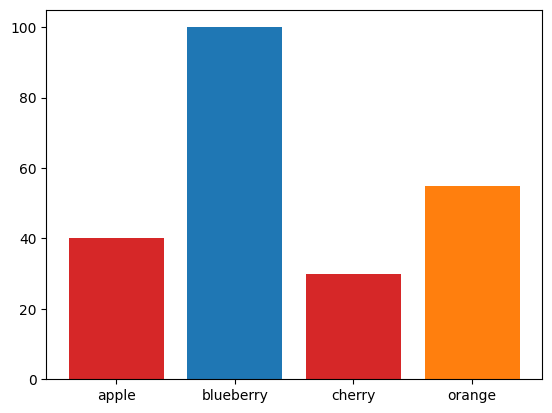

In [20]:
with Context("root") as root:
    with Context("first", meta={"color": "lightgreen"}):
        pass
    with Context("second", meta={"color": "lightblue"}):
        pass        

    fig, ax = plt.subplots()
    
    fruits = ['apple', 'blueberry', 'cherry', 'orange']
    counts = [40, 100, 30, 55]
    bar_labels = ['red', 'blue', '_red', 'orange']
    bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
    
    ax.bar(fruits, counts, label=bar_labels, color=bar_colors)
    
    with Context("image demo", inputs={"my_chart": capture_figure(), "other_param": 42}) as root2:
        pass

In [21]:
# get current context

with Context("root") as c:
    with Context("child"):
        current_context().add_tag("tag1")

show(c.to_dict())

{
  "_type": "Context",
  "name": "root",
  "uid": "2023-07-27T23:19:30-root-lhxZPd",
  "children": [
    {
      "_type": "Context",
      "name": "child",
      "uid": "2023-07-27T23:19:30-child-LIwQaw",
      "tags": [
        "tag1"
      ],
      "start_time": "2023-07-27T23:19:30.808975",
      "end_time": "2023-07-27T23:19:30.808990"
    }
  ],
  "start_time": "2023-07-27T23:19:30.808888",
  "end_time": "2023-07-27T23:19:30.808995"
}


### Events

In [22]:
# Events (instant context with immediate result)

with Context("root") as c:
    c.add_event("Message to Alice", kind="message", data="Hi, Alice!")

show(c.to_dict())

{
  "_type": "Context",
  "name": "root",
  "uid": "2023-07-27T23:19:34-root-p5FHKL",
  "children": [
    {
      "_type": "Context",
      "name": "Message to Alice",
      "uid": "2023-07-27T23:19:34-Message_to_Alice-Cd9eKm",
      "state": "event",
      "kind": "message",
      "result": "Hi, Alice!",
      "end_time": "2023-07-27T23:19:34.093357"
    }
  ],
  "start_time": "2023-07-27T23:19:34.093318",
  "end_time": "2023-07-27T23:19:34.093368"
}


### Storage

In [23]:
# Register context into storage
storage=interlab.context.FileStorage("/tmp/interlab")
with Context("root1", storage=storage):
    pass


In [24]:
# Manual writing context into storage

with Context("root2", tags=["hello"]) as c:
    pass

storage.write_context(c)

In [26]:
# Composing directory structure with contexts:
# each context subtree marked with `directory=True` getns stored in a separete json rather than in the main json

with Context("root3", storage=storage, directory=True) as root:
    with Context("first child", directory=True):
        with Context("a"):
            pass
        with Context("b", tags=["hello"]):
            pass
    with Context("second child", directory=True):
        with Context("a"):
            pass
        with Context("b"):
            pass

import pathlib
list(pathlib.Path(f"{storage.directory}/{root.uid}.ctx").rglob("*"))

[PosixPath('/tmp/interlab/2023-07-27T23:20:43-root3-MoJMCK.ctx/_self.gz'),
 PosixPath('/tmp/interlab/2023-07-27T23:20:43-root3-MoJMCK.ctx/2023-07-27T23:20:43-first_child-Fru5F5.ctx'),
 PosixPath('/tmp/interlab/2023-07-27T23:20:43-root3-MoJMCK.ctx/2023-07-27T23:20:43-second_child-WfOHQa.ctx'),
 PosixPath('/tmp/interlab/2023-07-27T23:20:43-root3-MoJMCK.ctx/2023-07-27T23:20:43-first_child-Fru5F5.ctx/_self.gz'),
 PosixPath('/tmp/interlab/2023-07-27T23:20:43-root3-MoJMCK.ctx/2023-07-27T23:20:43-first_child-Fru5F5.ctx/2023-07-27T23:20:43-a-n3yIOo.full.gz'),
 PosixPath('/tmp/interlab/2023-07-27T23:20:43-root3-MoJMCK.ctx/2023-07-27T23:20:43-first_child-Fru5F5.ctx/2023-07-27T23:20:43-a-n3yIOo.root.gz'),
 PosixPath('/tmp/interlab/2023-07-27T23:20:43-root3-MoJMCK.ctx/2023-07-27T23:20:43-first_child-Fru5F5.ctx/2023-07-27T23:20:43-b-f4cj46.full.gz'),
 PosixPath('/tmp/interlab/2023-07-27T23:20:43-root3-MoJMCK.ctx/2023-07-27T23:20:43-first_child-Fru5F5.ctx/2023-07-27T23:20:43-b-f4cj46.root.gz'),
 Pos

### Data browser

In [27]:
# Running data browser over storage

storage.start_server()

[2023-07-27 23:20:48,187] INFO(interlab.ui.storage_server): Started context UI server: <ServerHandle http://localhost:46331>


<ServerHandle http://localhost:46331>

In [29]:
# Long running cell, you can observe it in browser in running state (nneds to be refreshed manually)

with Context("Long running", storage=storage):
    with Context("Child1"):
        import time
        time.sleep(10)

In [30]:
# Read all stored (root) contexts

for context in storage.read_all_contexts():
    print(context.uid, context.name)

2023-07-27T23:19:36-root1-Xbml3w root1
2023-07-27T23:19:38-root2-dnOjNj root2
2023-07-27T23:20:50-Long_running-jdgbbZ Long running
2023-07-27T23:21:15-Long_running-zT7YuF Long running
2023-07-27T23:19:40-root3-UsT2aG root3
2023-07-27T23:20:43-root3-MoJMCK root3


In [31]:
# Recursively search for specific contexts

for context in storage.find_contexts(lambda ctx: ctx.has_tag_name("hello")):
    print(context.uid, context.name)

2023-07-27T23:19:38-root2-dnOjNj root2
2023-07-27T23:19:40-b-eUBBcE b
2023-07-27T23:20:43-b-f4cj46 b


In [32]:
# Read a context by uid

context = storage.read_context(root.uid)
print(context.uid, context.name)


# Search in a given context

context.find_contexts(lambda x: x.name == "a")

2023-07-27T23:20:43-root3-MoJMCK root3
